In [306]:
import re
import patsy
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
from utils.EDA.analysis import *
import warnings

In [307]:
# report 확인
def LinearRegR(data, formula):
    model = sm.OLS.from_formula(formula, data)
    result = model.fit()
    print(result.summary())
    return result
    

def plot_pre_tar(result, data, tar):
    predict = result.predict(data).values

    target = data[tar].values
    plt.scatter(target, predict)
    
    return result
    
# 예측치와 추정치 결과 확인 (위치도 출력)
# plot_leverage_resid2, influence_plot 확인
def LinearReg(data, formula):
    model = sm.OLS.from_formula(formula, data)
    result = model.fit()
    
    predict = result.predict(data).values

    y = formula.split("~")[0].strip()
    target = data[y].values
    plt.scatter(target, predict)
    
    return result
    
    
def LinearRegO(data, formula, num_param):
    model = sm.OLS.from_formula(formula, data)
    result = model.fit()
    
    predict = result.predict(data).values

    y = formula.split("~")[0].strip()
    target = data[y].values

#     ax = plt.subplot()
#     plt.scatter(target, predict)
#     cook_d2, pvals = result.get_influence().cooks_distance
#     fox_cr = 4 / (len(y) - num_param)
#     idx = np.where(cook_d2 > fox_cr)[0]
#     plt.scatter(target[idx], predict[idx], s=300, c="r", alpha=0.5)
#     utils.annotate_axes(range(len(idx)), idx, 
#                     list(zip(target[idx], predict[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
    
    
    sm.graphics.influence_plot(result)
    
def plot_Exo(result, column_list):
    
    for c in columns_list:
        fig = sm.graphics.plot_regress_exog(result, c)
        fig.set_size_inches(10, 10)
# 그래프 보기( 잔차 ) / 컬럼 값이 입력
# plot_regress_exog(fitting plit, residal-x, partial, CCPR)

In [308]:
def makeFormula(target, numeric=None, categoric=None, noInter = False, scale = False):
    formula = ""
    formula += target
    formula += "~"
    
    if(numeric != None):
        if scale == True:
            numeric = list(map(lambda c :  "scale(" + c + ")", numeric))
        formula_numeric = "+".join(numeric)
        formula += formula_numeric 
    
    if(numeric != None and categoric != None):
        formula += "+"
    
    if(categoric != None):
        categoric = list(map(lambda c :  "C(" + c + ")", categoric))
        formula_categoric = "+".join(categoric)
        formula += formula_categoric
    
    if(noInter == True):
        formula +="+0"
    
    return formula

In [309]:
def makeFormula_scale(target, scale=None, non_scale=None, noInter=False):
    formula = ""
    formula += target
    formula += "~"
    
    if(scale != None):
        scale = list(map(lambda c :  "scale(" + c + ")", scale))
        formula_scale = "+".join(scale)
        formula += formula_scale 
    
    if(scale != None and non_scale != None):
        formula += "+"
    
    if(non_scale != None):
        formula_non_scale = "+".join(non_scale)
        formula += formula_non_scale
    
    if(noInter == True):
        formula +="+0"
    
    return formula

In [310]:
# Backward method
def backwarding_method(data, target, numeric_list, categoric_list, scale=False, debug = False):
    num_iter = 0
    isLoop = True
    
    while(isLoop):
        num_iter += 1
        column_list=[]
        if numeric_list != None:
            column_list += numeric_list
        if categoric_list != None:
            column_list += categoric_list
        
        if(scale == False):
            model = sm.OLS.from_formula(makeFormula_scale(target, None, column_list, True), data)
            result = model.fit()
        
        if(scale == True):
#             formula = makeFormula_scale(target, numeric_list, categoric_list, True)
#             print(formula)
#             model = sm.OLS.from_formula(formula, data)
            result = model.fit()

        pvalues = result.pvalues
        max_index = pvalues.sort_values(ascending = False).index[0]
        max_value = pvalues.sort_values(ascending = False).values[0]
        if  re.match(r'scale\((\w+)\)', max_index):
            max_index = re.sub(r"scale\((\w+)\)", r"\g<1>", max_index)
        
        if debug == True:
            print("{} 단계 : max_t_value : ({}, {}) \n".format(num_iter, max_index, max_value))

            print("현재 list : ", end = "")
            for c in column_list:
                print("{}, ".format(c), end = "")
            print("\n")
            
        if max_value > 0.01:
            if numeric_list != None:
                if max_index in numeric_list:
                    numeric_list.remove(max_index)
                    print("numeric")
                    
            if categoric_list != None:
                if max_index in categoric_list:
                    categoric_list.remove(max_index)
                    print("categoric")
                    
            isLoop = True
        else:
            isLoop = False
        
        
    print("{} 시도만에 작업 끝!! : 정제된 목록 리스트 ".format(num_iter))
    print("numeric list : ", numeric_list)
    print("categoric list : ", categoric_list)
    print()
    
    return numeric_list, categoric_list

In [311]:
def crossValidation(data, formula, split_num = 5, iter_num = 5, debug = False):
    rmsd_sum = 0
    r2_sum = 0
    num_iter=0
    
    for idx in range(iter_num):
        df_Y, df_X = patsy.dmatrices(formula, data=data, return_type='dataframe')
        df_cv_train_Y, df_cv_test_Y, df_cv_train_X, df_cv_test_X = train_test_split(df_Y, df_X, test_size=len(df_train)//split_num)

        model = sm.OLS(df_cv_train_Y, df_cv_train_X)
        result = model.fit()
        result.summary()

        predict = result.predict(df_cv_test_X).values[:, np.newaxis]
        target = df_cv_test_Y.values
        
        # get rmsd
        square_y = (predict - target) ** 2
        rmsd = np.sqrt(square_y.sum() / len(df_cv_test_Y))
        
        # get r2
        r2 = r2_score(target, predict)
        
        if debug == True:
            print("{}차 시도!!!".format(num_iter+1))
            print("rmsd : ", rmsd)
            print("r2 : ", r2)
            print()

        rmsd_sum += rmsd
        r2_sum += r2
        num_iter +=1
    
    rmsd_avr = rmsd_sum / iter_num
    r2_avr = r2_sum / iter_num
    print("rmsd_avr : ", rmsd_avr)
    print("test_r2 : ", r2_avr)
    
    return rmsd_avr, r2_avr

# read file

In [312]:
df_train = pd.read_csv("../data/train_no_missing.csv")
df_test = pd.read_csv("../data/test_no_missing.csv")

nuTocaList = ["MSSubClass", "MoSold", "YrSold", "OverallQual", "OverallCond"]
df_train[nuTocaList] = df_train[nuTocaList].astype("str")
df_test[nuTocaList] = df_test[nuTocaList].astype("str")

df_all = pd.concat([df_train, df_test])
df_all.reset_index(drop = True, inplace = True)

df_all = pd.get_dummies(df_all)
df_train_dummy = df_all.iloc[:1460]
df_test_dummy = df_all.iloc[1460:]

df_train_dummy.reset_index(drop=True, inplace =True)
df_test_dummy.reset_index(drop=True, inplace =True)

df_test_dummy.drop("SalePriceLog", axis = 1, inplace = True)

C:\Users\magenta_jy\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [313]:
df_train.shape, df_test.shape, df_train_dummy.shape, df_test_dummy.shape

((1460, 81), (1459, 80), (1460, 351), (1459, 350))

# Numeric data 

## make numeric data

In [314]:
#get numeric data and categoric data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_list = list(df_test.select_dtypes(include=numerics).columns)

print(len(numeric_list))

32


## numeric data VIF확인

In [315]:
df_scale_numeric = pd.DataFrame()
# scale지정
for c in numeric_list:
    if c == "Id":
        continue
    df_scale_numeric[c+"Scale"] = scale(df_train[c])

C:\Users\magenta_jy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [316]:
df_scale_numeric.drop("TotalBsmtSFScale", axis = 1, inplace = True)
df_scale_numeric.drop("GrLivAreaScale", axis = 1, inplace = True)

In [317]:
df_X0 = df_scale_numeric.copy()
df_vif = pd.DataFrame()
df_vif["VIF Factor"] = [variance_inflation_factor(df_X0.values, i) for i in range(df_X0.shape[1])]
df_vif["features"] = df_X0.columns

df_vif.sort_values(by = "VIF Factor", ascending = False)

,VIF Factor,features
0,5.990131,FirstFlrSFScale
12,5.635211,GarageAreaScale
13,5.414249,GarageCarsScale
4,5.348237,BsmtFinSF1Scale
27,5.204431,YearBuiltScale
1,5.144960,SecondFlrSFScale
14,4.860373,GarageYrBltScale
25,4.792594,TotRmsAbvGrdScale
8,3.901344,BsmtUnfSFScale
11,2.899403,FullBathScale


In [318]:
df_scale_numeric["SalePriceLog"] = df_train["SalePriceLog"]

In [319]:
# # TotalBsmtSF 제거 (TotalBsmtSF, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF)
# column_list.remove("TotalBsmtSF")
# numeric_list.remove("TotalBsmtSF")

# # YearRemodel 제거 (나중에 했다 않했다로 생성)
# column_list.remove("YearRemodAdd")
# numeric_list.remove("YearRemodAdd")

# column_list.remove("log_GrLivArea")
# numeric_list.remove("log_GrLivArea")

In [320]:
# model = sm.OLS.from_formula(makeFormula_scale(target, ["OpenPorchSFpow2"], ["Condition1_Norm"], True), df_train)

In [321]:
# formula = makeFormula_scale(target, numeric_list, categoric_list, True)
# print(formula)
# model = sm.OLS.from_formula(str(formula), data)

# Lasso Reguralize

In [322]:
non_scale_list = list(df_scale_numeric.columns)
non_scale_list.remove("SalePriceLog")

In [323]:
len(non_scale_list)

29

In [324]:
formula = makeFormula_scale("SalePriceLog", None, non_scale_list, False)
model = sm.OLS.from_formula(formula, df_scale_numeric)

In [325]:
alpha_list = np.logspace(-5, 1, 100)

In [326]:
data = [] # lasso 확인 시 사용
zero_idx_list = []
rmsd_test_list = []
r2_test_list = []
column_test_list = []

df_cv = pd.DataFrame()

for idx, a in enumerate(alpha_list):
    result = model.fit_regularized(alpha = a, L1_wt=1)
    new_zero_idx_list = []
    
    for idx2, param in enumerate(result.params):
        if round(param, 4) == 0:
            if idx2 not in zero_idx_list:
                new_zero_idx_list.append(idx2)
    
    if(len(new_zero_idx_list) > 0):          
        print("{}차 시도 !!".format(idx))
        print("새롭게 0이 된 특징")
        for new_zero_idx in new_zero_idx_list:
            print(" {} : {} ".format(result.params.index[new_zero_idx], result.params.values[new_zero_idx]))
        zero_idx_list += new_zero_idx_list
        
        # 실제 선형 회귀한 model의 cross validation 출력
        non_zero_list = set(non_scale_list) - set(result.params.index[zero_idx_list])
        print(len(non_zero_list))
        
        if(len(non_zero_list) > 0):
            model_test = sm.OLS.from_formula(makeFormula_scale("SalePriceLog", None, non_zero_list, False), df_scale_numeric)
            result_test = model_test.fit()
            rmsd_test, r2_test = crossValidation(df_scale_numeric, makeFormula_scale("SalePriceLog", None, non_zero_list, False), 5, 100)

            rmsd_test_list.append(rmsd_test)
            r2_test_list.append(r2_test)
            column_test_list.append(non_zero_list)
            print()
        
        
#     print("현재 0인 특징")
#     for zero_idx in zero_idx_list:
#         print(" {} : {}".format(result.params.index[zero_idx], result.params.values[zero_idx]), end =", "
    
    data.append(result.params)
    

18차 시도 !!
새롭게 0이 된 특징
 LotFrontageScale : 0.0 
28
rmsd_avr :  0.18631416195
test_r2 :  0.774084312016

21차 시도 !!
새롭게 0이 된 특징
 GarageYrBltScale : 0.0 
27
rmsd_avr :  0.181404322523
test_r2 :  0.786850106587

23차 시도 !!
새롭게 0이 된 특징
 BedroomAbvGrScale : 0.0 
26
rmsd_avr :  0.17594004875
test_r2 :  0.798333058099

24차 시도 !!
새롭게 0이 된 특징
 OpenPorchSFScale : 0.0 
25
rmsd_avr :  0.175316484701
test_r2 :  0.802457711124

32차 시도 !!
새롭게 0이 된 특징
 MasVnrAreaScale : 0.0 
 TotRmsAbvGrdScale : 0.0 
23
rmsd_avr :  0.182696464203
test_r2 :  0.779401609034

35차 시도 !!
새롭게 0이 된 특징
 EnclosedPorchScale : 0.0 
22
rmsd_avr :  0.178054036667
test_r2 :  0.795154281817

37차 시도 !!
새롭게 0이 된 특징
 LowQualFinSFScale : 0.0 
21
rmsd_avr :  0.182247310789
test_r2 :  0.786286574562

40차 시도 !!
새롭게 0이 된 특징
 MiscValScale : 0.0 
20
rmsd_avr :  0.180043498583
test_r2 :  0.789359892079

43차 시도 !!
새롭게 0이 된 특징
 ThreeSsnPorchScale : 0.0 
19
rmsd_avr :  0.183809438911
test_r2 :  0.776401414911

45차 시도 !!
새롭게 0이 된 특징
 BsmtHalfBathScal

In [327]:
df_lasso = pd.DataFrame(data, columns = non_scale_list, index = alpha_list)

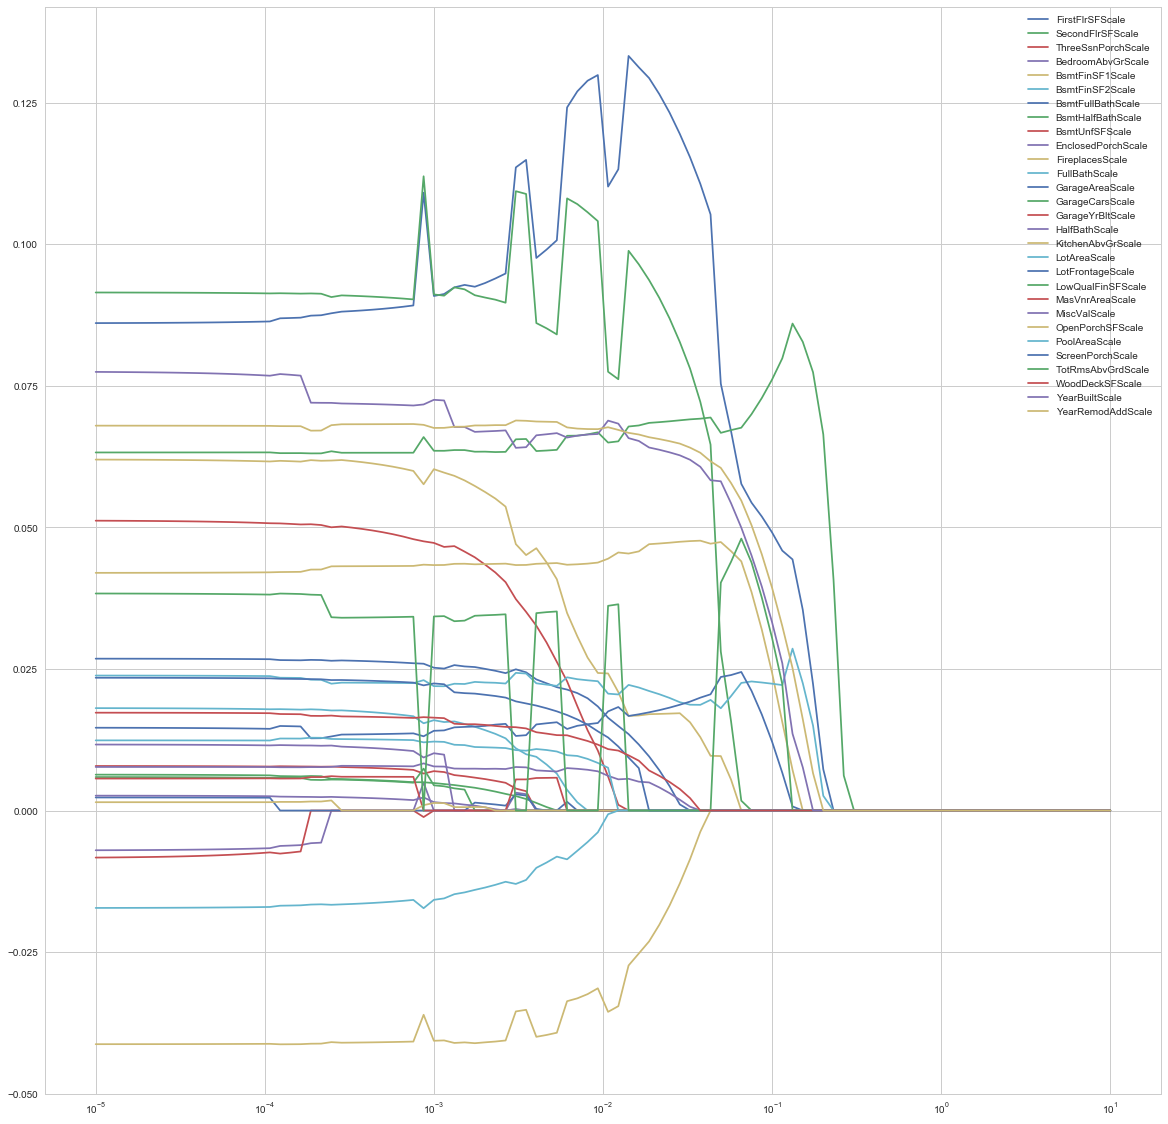

In [328]:
flg = plt.figure(figsize = (20, 20))
plt.semilogx(df_lasso)
plt.legend(non_scale_list)

plt.show()

Text(0,0.5,'test_rmsd')

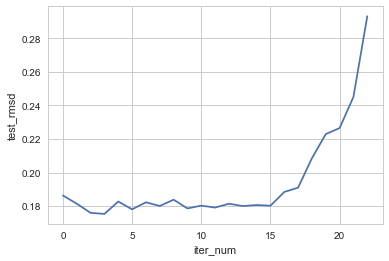

In [329]:
# show rmsd-test <-> iter
num_iter_test = len(rmsd_test_list)
plt.plot(range(num_iter_test), rmsd_test_list)
plt.xlabel("iter_num")
plt.ylabel("test_rmsd")

Text(0,0.5,'test_r2')

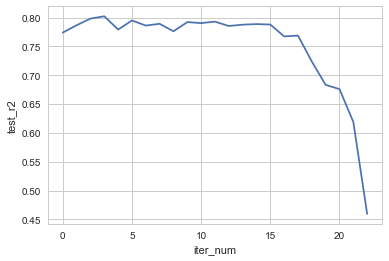

In [330]:
# show r2-test <-> iter
plt.plot(range(0, num_iter_test), r2_test_list)
plt.xlabel("iter_num")
plt.ylabel("test_r2")

0, 12-16

# t-test 검정으로 제거

 하나도 제거하지 않을 때 성능이 제일 높게 나와 넘어간다. 

# Categorical data

In [331]:
categoric_list = list(df_train.select_dtypes(include = ["object"]).columns)
categoric_dummy_list = list(df_train_dummy.filter(regex = "_").columns)

df_scale_cate = pd.concat([df_scale_numeric, df_train[categoric_list]], axis = 1)
df_scale_cate_dummy = pd.concat([df_scale_numeric, df_train_dummy[categoric_dummy_list]], axis = 1)

len(categoric_list), len(categoric_dummy_list), df_scale_cate.shape, df_scale_cate_dummy.shape 

(48, 318, (1460, 78), (1460, 348))

## One way Test (차이가 많이 없는 것 제거)

In [332]:
df_one_anova_Fvalue = pd.DataFrame(columns = ["name", "Fvalue"])

for idx, c in enumerate(categoric_list):
    model = sm.OLS.from_formula("SalePriceLog ~ C({})".format(c), data=df_train)
    result = model.fit()
    df_tmp=sm.stats.anova_lm(result)
    df_one_anova_Fvalue.loc[idx] = {"name":c, "Fvalue":df_tmp['PR(>F)'][0]}   

df_one_anova_Fvalue.sort_values(by=["Fvalue"], ascending=False, inplace=True)
df_one_anova_Fvalue.reset_index(drop=True, inplace=True)
df_one_anova_Fvalue

C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\magenta_jy\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,name,Fvalue
0,Utilities,6.296086e-01
1,YrSold,5.656386e-01
2,MoSold,4.496614e-01
3,LandSlope,3.388339e-01
4,Street,2.837965e-02
5,Condition2,1.382043e-02
6,PoolQC,7.695369e-03
7,MiscFeature,6.060004e-03
8,RoofMatl,4.504077e-04
9,Functional,4.250494e-06


In [333]:
over_one_Fvalue_list = list(df_one_anova_Fvalue[df_one_anova_Fvalue["Fvalue"] > 0.01]["name"])
over_one_Fvalue_list

['Utilities', 'YrSold', 'MoSold', 'LandSlope', 'Street', 'Condition2']

In [334]:
over_one_Fvalue_dummy_list=[]
for c in over_one_Fvalue_list:
    reg = c+"_"
    tmp = list(df_test_dummy.filter(regex = reg))
    for a in tmp:
        over_one_Fvalue_dummy_list.append(a)
        
over_one_Fvalue_dummy_list

['Utilities_AllPub',
 'Utilities_NoSeWa',
 'YrSold_2006',
 'YrSold_2007',
 'YrSold_2008',
 'YrSold_2009',
 'YrSold_2010',
 'MoSold_1',
 'MoSold_10',
 'MoSold_11',
 'MoSold_12',
 'MoSold_2',
 'MoSold_3',
 'MoSold_4',
 'MoSold_5',
 'MoSold_6',
 'MoSold_7',
 'MoSold_8',
 'MoSold_9',
 'LandSlope_Gtl',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Street_Grvl',
 'Street_Pave',
 'Condition2_Artery',
 'Condition2_Feedr',
 'Condition2_Norm',
 'Condition2_PosA',
 'Condition2_PosN',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn']

In [335]:
# 제거 high one-way Fvalue
for c in over_Fvalue_list:
    categoric_list.remove(c)
    
for c in over_one_Fvalue_dummy_list:
    categoric_dummy_list.remove(c)
    

In [336]:
len(categoric_list), len(over_Fvalue_list), len(categoric_dummy_list), len(over_one_Fvalue_dummy_list)

(42, 6, 286, 32)

## Numeric data + categorical data 1개 (F-value)

In [371]:
categoric_list = list(df_train.select_dtypes(include = ["object"]).columns)

df_numer_cate_Fvalue = pd.DataFrame(columns = ["name", "Fvalue"])

for idx, c in enumerate(categoric_list):
    model = sm.OLS.from_formula(makeFormula("SalePriceLog", non_scale_list, [c], False), df_scale_cate)
    result = model.fit()
    df_tmp = sm.stats.anova_lm(result, typ=2)
    df_numer_cate_Fvalue.loc[idx] = {"name":c, "Fvalue":df_tmp['PR(>F)'][0]}
    
df_numer_cate_Fvalue.sort_values(by=["Fvalue"], ascending = False, inplace=True)
df_numer_cate_Fvalue.reset_index(drop=True, inplace=True)

In [366]:
df_numer_cate_Fvalue

,name,Fvalue
0,RoofStyle,5.136022e-01
1,LandSlope,4.082687e-01
2,Utilities,4.018343e-01
3,Electrical,2.034616e-01
4,Alley,1.984419e-01
5,MoSold,1.926268e-01
6,YrSold,1.896241e-01
7,Fence,1.244302e-01
8,LotConfig,9.198568e-02
9,BsmtFinType2,4.939157e-02


In [372]:
over_numer_cate_Fvalue_list = list(df_numer_cate_Fvalue[df_numer_cate_Fvalue["Fvalue"] > 0.01]["name"])
over_numer_cate_Fvalue_list

['RoofStyle',
 'LandSlope',
 'Utilities',
 'Electrical',
 'Alley',
 'MoSold',
 'YrSold',
 'Fence',
 'LotConfig',
 'BsmtFinType2',
 'MiscFeature',
 'Heating',
 'HouseStyle',
 'Exterior2nd',
 'MasVnrType']

In [373]:
over_numer_cate_Fvalue_dummy_list = []

for c in over_numer_cate_Fvalue_list:
    reg = c+"_"
    tmp = list(df_test_dummy.filter(regex = reg))
    for a in tmp:
        over_numer_cate_Fvalue_dummy_list.append(a)

In [375]:
over_numer_cate_Fvalue_dummy_list

['RoofStyle_Flat',
 'RoofStyle_Gable',
 'RoofStyle_Gambrel',
 'RoofStyle_Hip',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'LandSlope_Gtl',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Utilities_AllPub',
 'Utilities_NoSeWa',
 'Electrical_FuseA',
 'Electrical_FuseF',
 'Electrical_FuseP',
 'Electrical_Mix',
 'Electrical_SBrkr',
 'Alley_Grvl',
 'Alley_None',
 'Alley_Pave',
 'MoSold_1',
 'MoSold_10',
 'MoSold_11',
 'MoSold_12',
 'MoSold_2',
 'MoSold_3',
 'MoSold_4',
 'MoSold_5',
 'MoSold_6',
 'MoSold_7',
 'MoSold_8',
 'MoSold_9',
 'YrSold_2006',
 'YrSold_2007',
 'YrSold_2008',
 'YrSold_2009',
 'YrSold_2010',
 'Fence_GdPrv',
 'Fence_GdWo',
 'Fence_MnPrv',
 'Fence_MnWw',
 'Fence_None',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'BsmtFinType2_ALQ',
 'BsmtFinType2_BLQ',
 'BsmtFinType2_GLQ',
 'BsmtFinType2_LwQ',
 'BsmtFinType2_None',
 'BsmtFinType2_Rec',
 'BsmtFinType2_Unf',
 'MiscFeature_Gar2',
 'MiscFeature_None',
 'MiscFeature_Othr',
 'MiscFea

In [368]:
# remove high f value
# 제거 high one-way Fvalue
for c in over_numer_cate_Fvalue_list:
    categoric_list.remove(c)
    
for c in over_numer_cate_Fvalue_dummy_list:
    categoric_dummy_list.remove(c)

ValueError: list.remove(x): x not in list

# t-test를 통해서 카테고리값 하나씩 제거

# Outlier 제거

# partial plot 확인

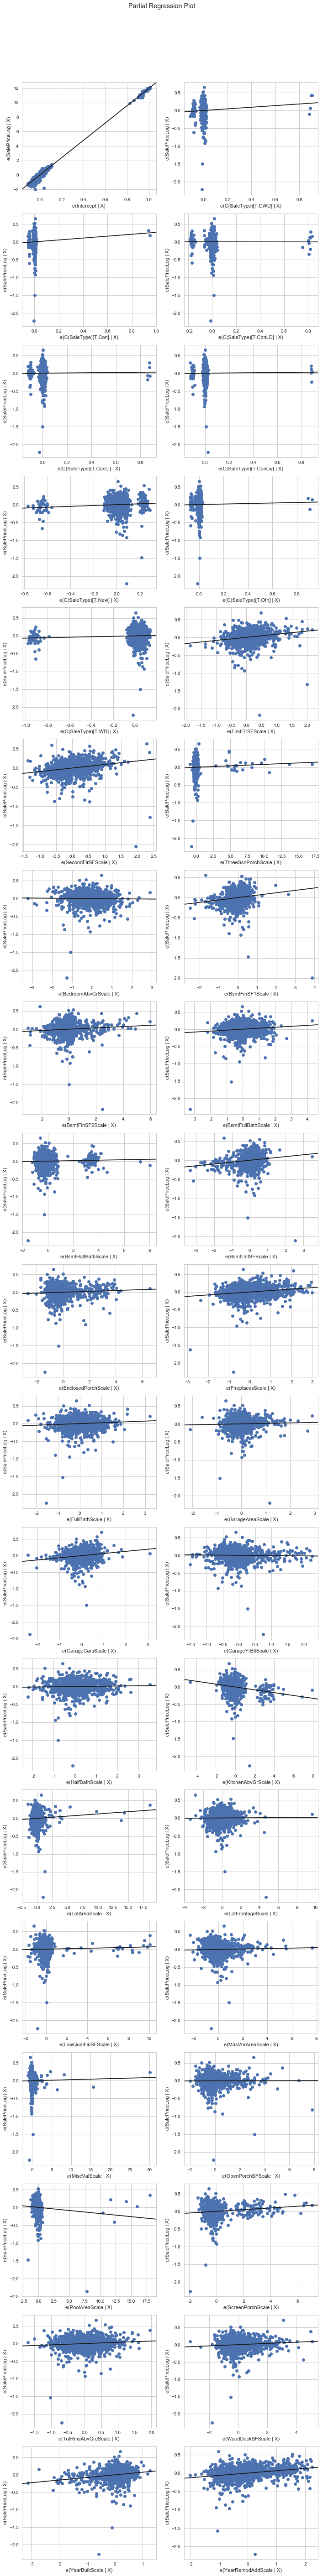

In [344]:
fig = plt.figure(figsize = (10, 80))
sm.graphics.plot_partregress_grid(result, fig=fig)
plt.show()

# CCPR plot

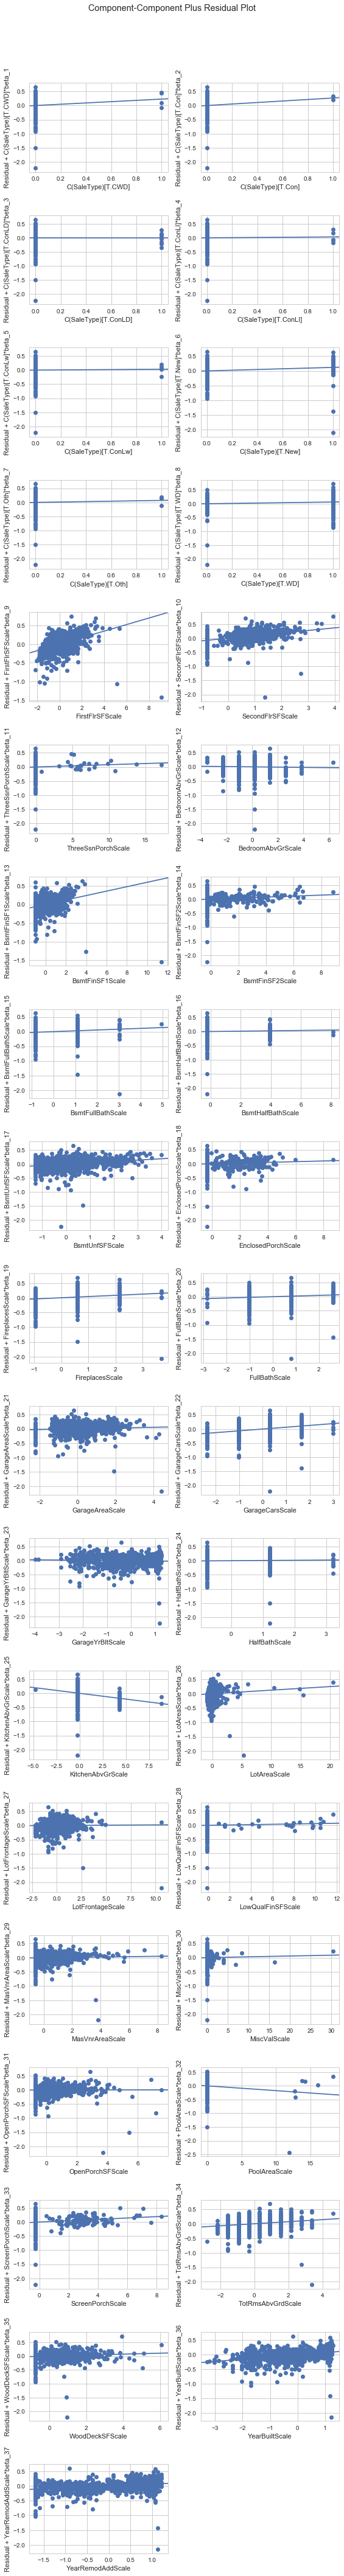

In [345]:
fig = plt.figure(figsize = (8, 60))
sm.graphics.plot_ccpr_grid(result, fig=fig)
plt.show()

# 항상 보이는 아웃라이어 두개 삭제

In [346]:
# from statsmodels.graphics import utils

# influence = result.get_influence()

# cooks_d2, pvals = influence.cooks_distance
# fox_cr = 4 / (len(y) - 2)
# idx = np.where(cooks_d2 > fox_cr)[0]

# predict = result.predict(data).values

#     target = data[tar].values
#     plt.scatter(target, predict)

# ax = plt.subplot()
# plt.scatter(X0, y)
# plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
# utils.annotate_axes(range(len(idx)), idx, 
#                     list(zip(X0[idx], y[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
# plt.show()

# regress_exog

In [347]:
# for c in non_scale_list:
#     sm.graphics.plot_regress_exog(result, c)

In [348]:
# data=df_train
# target="SalePriceLog" 
# scale=True
# debug = False
# num_iter = 0
# isLoop = True

# while(isLoop):
#     num_iter += 1
#     column_list=[]
#     if numeric_list != None:
#         column_list += numeric_list
#     if categoric_list != None:
#         column_list += categoric_list

#     if(scale == False):
#         model = sm.OLS.from_formula(makeFormula_scale(target, None, column_list, True), data)
#         result = model.fit()

#     if(scale == True):
#         formula = makeFormula_scale(target, numeric_list, categoric_list, True)
#         model = sm.OLS.from_formula(formula, data)
#         result = model.fit()

#     pvalues = result.pvalues
#     max_index = pvalues.sort_values(ascending = False).index[0]
#     max_value = pvalues.sort_values(ascending = False).values[0]
#     if  re.match(r'scale\((\w+)\)', max_index):
#         max_index = re.sub(r"scale\((\w+)\)", r"\g<1>", max_index)

#     if debug == True:
#         print("{} 단계 : max_t_value : ({}, {}) \n".format(num_iter, max_index, max_value))

#         print("현재 list : ", end = "")
#         for c in column_list:
#             print("{}, ".format(c), end = "")
#         print("\n")

#     if max_value > 0.01:
#         if numeric_list != None:
#             if max_index in numeric_list:
#                 numeric_list.remove(max_index)
#                 print("numeric")

#         if categoric_list != None:
#             if max_index in categoric_list:
#                 categoric_list.remove(max_index)
#                 print("categoric")

#         isLoop = True
#     else:
#         isLoop = False


# print("{} 시도만에 작업 끝!! : 정제된 목록 리스트 ".format(num_iter))
# print("numeric list : ", numeric_list)
# print("categoric list : ", categoric_list)
# print()

# 

# 결과 확인

In [349]:
model = sm.OLS.from_formula(makeFormula_scale("SalePriceLog", None, list(non_scale_list), False), df_scale_numeric)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           SalePriceLog   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     227.0
Date:                Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                        12:37:19   Log-Likelihood:                 526.65
No. Observations:                1460   AIC:                            -993.3
Df Residuals:                    1430   BIC:                            -834.7
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             12.0241      0

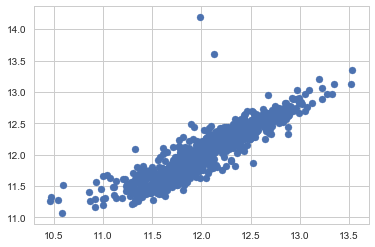

In [350]:
plot_pre_tar(result, df_scale_numeric, "SalePriceLog")

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([-2.20684428, -1.46972361, -0.91820538, ...,  0.52837861,
          0.55662001,  0.65683915])),
 (0.1567729168097404, -9.3975762534318864e-15, 0.92747210672293279))

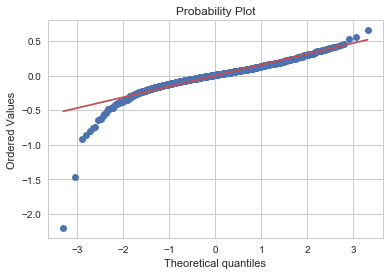

In [351]:
# 잔차의 정규성 확인
sp.stats.probplot(result.resid, plot =plt)

In [352]:
# crossValidation(df_train, makeFormula_scale("SalePriceLog", None, numeric_list+categoric_list, True), 10, 100)

# make submit

In [353]:
## lasso test용
df_test_scale = pd.DataFrame()
# scale지정
for c in numeric_list:
    df_test_scale[c+"Scale"] = scale(df_test[c])
df_test_scale.drop("TotalBsmtSFScale", axis = 1, inplace = True)
df_test_scale.drop("GrLivAreaScale", axis = 1, inplace = True)

#categoric 입력    
df_test_scale = pd.concat([df_test_scale, df_test_dummy[categoric_dummy_list]], axis=1)

#모델 생성
model = sm.OLS.from_formula(makeFormula("SalePriceLog", non_scale_list + categoric_dummy_list, None, True), df_scale_cate_dummy)
result = model.fit()

# 계산
y = result.predict(df_test_scale)
y = np.exp(y)
print(y)


# sumit 만들기
df_sumit = pd.DataFrame(columns = ["Id", "SalePrice"])
df_sumit["Id"] =df_test["Id"]
df_sumit["SalePrice"] = y

df_sumit.to_csv("../submit/submit.csv", index = False)

C:\Users\magenta_jy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


0       124392.789098
1       155899.644797
2       186811.004625
3       203999.025562
4       203786.333969
5       173083.989730
6       186610.074452
7       168221.388972
8       192187.010104
9       123709.515879
10      185826.630469
11      101632.433510
12       99135.775659
13      147421.150237
14      119914.437645
15      374971.815363
16      247390.608422
17      284998.256832
18      290185.967391
19      559226.368218
20      335910.493669
21      212936.684354
22      173671.476451
23      164655.723433
24      187002.449949
25      192884.384521
26      348418.780714
27      238971.710862
28      195628.284364
29      245179.285577
            ...      
1429     88179.801080
1430    142752.726407
1431     36113.600510
1432     58587.303623
1433     49285.538131
1434    318840.087632
1435    277041.047209
1436    204762.123607
1437    133141.553017
1438    200826.935668
1439    157998.469263
1440    204077.446235
1441    164549.846427
1442    315270.825875
1443    35

In [354]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           SalePriceLog   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     91.38
Date:                Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                        12:37:21   Log-Likelihood:                 1293.7
No. Observations:                1460   AIC:                            -2173.
Df Residuals:                    1253   BIC:                            -1079.
Df Model:                         206                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
FirstFlrSFScale           0.0842      0.010      8.604      0.000       0.065       0.103
SecondFlrSFScale          0.0919      0.010      8.779      0.000       0.071       0.112
ThreeSsnPorchScale        0.0065      0.003      2.110      0.035       0.000       0.013
BedroomAbvGrScale         0.0054      0.005      1.026      0.305      -0.005       0.016
BsmtFinSF1Scale           0.0591      0.011      5.432      0.000       0.038       0.080
BsmtFinSF2Scale           0.0157      0.005      3.378      0.001       0.007       0.025
BsmtFullBathScale         0.0139      0.005      2.902      0.004       0.005       0.023
BsmtHalfBathScale         0.0016      0.003      0.466      0.641      -0.005       0.008
BsmtUnfSFScale            0.0366      0.010      3.844      0.000       0.018       0.055
EnclosedPorchScale        0.0086      0.004      2.436      0.015       0.002       0.016
FireplacesScale           0.0116      0.008      1.501      0.134      -0.004       0.027
FullBathScale             0.0155      0.006      2.739      0.006       0.004       0.027
GarageAreaScale           0.0194      0.008      2.459      0.014       0.004       0.035
GarageCarsScale           0.0216      0.008      2.707      0.007       0.006       0.037
GarageYrBltScale         -0.0022      0.007     -0.315      0.753      -0.016       0.012
HalfBathScale             0.0177      0.005      3.652      0.000       0.008       0.027
KitchenAbvGrScale        -0.0136      0.006     -2.406      0.016      -0.025      -0.003
LotAreaScale              0.0112      0.004      2.817      0.005       0.003       0.019
LotFrontageScale          0.0036      0.004      0.851      0.395      -0.005       0.012
LowQualFinSFScale         0.0049      0.004      1.314      0.189      -0.002       0.012
MasVnrAreaScale           0.0023      0.004      0.597      0.551      -0.005       0.010
MiscValScale              0.0003      0.003      0.101      0.920      -0.006       0.006
OpenPorchSFScale          0.0046      0.004      1.299      0.194      -0.002       0.011
PoolAreaScale             0.0765      0.033      2.331      0.020       0.012       0.141
ScreenPorchScale          0.0154      0.003      4.764      0.000       0.009       0.022
TotRmsAbvGrdScale         0.0113      0.007      1.579      0.115      -0.003       0.025
WoodDeckSFScale           0.0119      0.003      3.452      0.001       0.005       0.019
YearBuiltScale            0.0463      0.012      3.868      0.000       0.023       0.070
YearRemodAddScale         0.0167      0.005      3.120      0.002       0.006       0.027
BldgType_1Fam             0.3948      0.045      8.724      0.000       0.306       0.484
BldgType_2fmCon           0.3978      0.103      3.860      0.000       0.196       0.600
BldgType_Duplex        